# import

In [1]:
import fdtd
import numpy as np
import matplotlib.pyplot as plt
import os
import fdtd.backend as bd
fdtd.set_backend("numpy")

# constants

In [2]:
wavelenth = 632.8e-9

# grid

In [3]:
grid = fdtd.Grid(
    shape = (3e-6, 3e-6, 1), # --> 2D FDTD
    grid_spacing = 0.1*wavelenth,
    permittivity = 1,
)
# x boundaries
grid[0:1e-7, :, :] = fdtd.PML(name="pml_xlow")
grid[-1e-7:, :, :] = fdtd.PML(name="pml_xhigh")
# y boundaries
grid[:, 0:1e-7, :] = fdtd.PML(name="pml_ylow")
grid[:, -1e-7:, :] = fdtd.PML(name="pml_yhigh")


simfolder = grid.save_simulation("circle")  # initializing environment to save simulation data
print(simfolder)

D:\jypyter\fdtd_output\fdtd_output_2022-9-28-10-43-22 (circle)


# source

In [4]:
grid[:, 1e-7, 0] = fdtd.LineSource(
    period = wavelenth / (3e8), name="source"
)

# detector

In [5]:
grid[5e-7:25e-7, 20e-7:29e-7, 0] = fdtd.BlockDetector(name="detector")

# objects

In [6]:
refractive_index = 1.1689
x = y = np.linspace(-1e-7,1e-7,20)
X, Y = np.meshgrid(x, y)
circle_mask = X**2 + Y**2 < 1e-14
permittivity = np.ones((20,20,1))
permittivity += circle_mask[:,:,None]*(refractive_index**2 - 1)
grid[10:30, 10:30, 0] = fdtd.Object(permittivity=permittivity, name="object")

print(grid.shape)
print(grid.object.inverse_permittivity.shape)




(47, 47, 1)
(20, 20, 1, 3)


In [7]:
grid.run(total_time=200)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 166.35it/s]


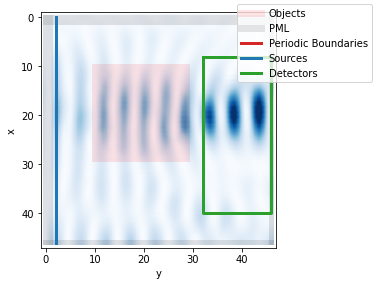

In [8]:
grid.visualize(z=0)

# simulations

In [9]:
with open(os.path.join(simfolder, "grid.txt"), "w") as f:
    f.write(str(grid))
    wavelength = 3e8/grid.source.frequency
    wavelengthUnits = wavelength/grid.grid_spacing
    GD = np.array([grid.x, grid.y, grid.z])
    gridRange = [np.arange(x/grid.grid_spacing) for x in GD]
    objectRange = np.array([[gridRange[0][x.x], gridRange[1][x.y], gridRange[2][x.z]] for x in grid.objects], dtype=object).T
    f.write("\n\nGrid details (in wavelength scale):")
    f.write("\n\tGrid dimensions: ")
    f.write(str(GD/wavelength))
    f.write("\n\tSource dimensions: ")
    f.write(str(np.array([grid.source.x[-1] - grid.source.x[0] + 1, grid.source.y[-1] - grid.source.y[0] + 1, grid.source.z[-1] - grid.source.z[0] + 1])/wavelengthUnits))
    f.write("\n\tObject dimensions: ")
    f.write(str([(max(map(max, x)) - min(map(min, x)) + 1)/wavelengthUnits for x in objectRange]))

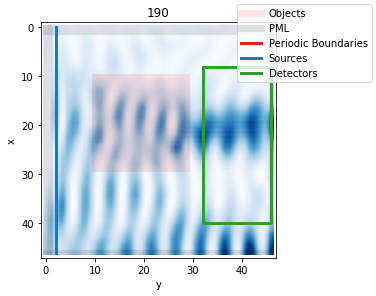

In [10]:
from IPython.display import clear_output # only necessary in jupyter notebooks
for i in range(200):
    grid.step()  # running simulation 1 timestep a time and animating
    if i % 10 == 0:
        # saving frames during visualization
        grid.visualize(z=0, animate=True, index=i, save=True, folder=simfolder)
        plt.title(f"{i:3.0f}")
        clear_output(wait=True) # only necessary in jupyter notebooks

grid.save_data()  # saving detector readings

In [11]:
try:
    video_path = grid.generate_video(delete_frames=False)  # rendering video from saved frames
except:
    video_path = ""
    print("ffmpeg not installed?")

if video_path:
    from IPython.display import Video
    display(Video(video_path, embed=True))

ffmpeg not installed?


# analyse

100%|█████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 189.16it/s]


Peak at: [[[12, 4]]]


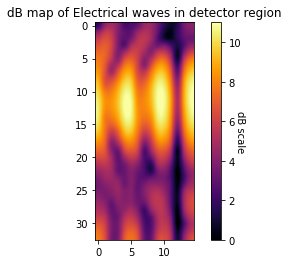

In [12]:
# analysing data stored by above simulation by plotting a 2D decibel map
df = np.load(os.path.join(simfolder, "detector_readings.npz"))
fdtd.dB_map_2D(df["detector (E)"])


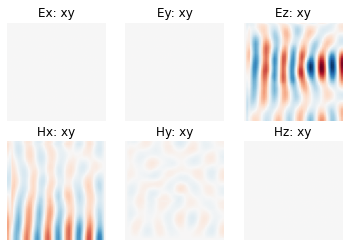

In [13]:
fig, axes = plt.subplots(2, 3, squeeze=False)
titles = ["Ex: xy", "Ey: xy", "Ez: xy", "Hx: xy", "Hy: xy", "Hz: xy"]
fields = bd.stack(
    [
        grid.E[:, :, 0, 0],
        grid.E[:, :, 0, 1],
        grid.E[:, :, 0, 2],
        grid.H[:, :, 0, 0],
        grid.H[:, :, 0, 1],
        grid.H[:, :, 0, 2],
    ]
)

m = max(abs(fields.min().item()), abs(fields.max().item()))

for ax, field, title in zip(axes.ravel(), fields, titles):
    ax.set_axis_off()
    ax.set_title(title)
    ax.imshow(bd.numpy(field), vmin=-m, vmax=m, cmap="RdBu")

plt.show()